In [163]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
# Style options for plots.
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998).
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Loading the dataset

In [164]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# Load the dataset
weld_df = pd.read_csv("../../data/clean_weld_quality_dataset_v2.csv")

# Shuffle the data to avoid bias when deleting labels
weld_df = shuffle(weld_df, random_state=1)

# Define features (X) and target variables (y)
target_cols = [
    'Yield strength / MPa',                             # Stress at which plastic deformation begins; measures strength.
    'Ultimate tensile strength / MPa',                  # Maximum stress material can withstand; key strength metric.
    'Elongation / %',                                   # Ductility measure; total strain before fracture.
    'Reduction of Area / %',                            # Ductility measure; cross-sectional area reduction after fracture.
    'Charpy temperature / °C',                          # Test temperature for Charpy impact test; defines test condition.
    'Charpy impact toughness / J',                      # Impact energy absorbed; indicates toughness and resistance to brittle fracture.
    'Hardness / kgmm-2',                                # Surface hardness; correlates with strength and wear resistance.
    '50 % FATT'                                         # Fracture Appearance Transition Temperature; temperature at which 50% brittle fracture occurs.
]

# Separate features and targets
X = weld_df.drop(columns=target_cols)
X = X.drop(columns=["Weld ID", "Type of weld;", "AC or DC", "Electrode positive or negative"]) # categorical features that were replaced by one-hot-encoding
y = weld_df[target_cols].to_numpy()


In [165]:
X.describe()

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Phosphorus concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),...,weld_type_NGSAW,weld_type_SA,weld_type_SAA,weld_type_ShMA,weld_type_TSA,current_AC,current_DC,electrode_+,electrode_-,electrode_0
count,1652.000000,1652.000000,1652.000000,1641.000000,1642.000000,697.000000,784.000000,791.000000,620.000000,564.000000,...,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,0.075521,0.328577,1.202821,0.009561,0.012952,0.415034,2.101273,0.480358,0.072443,0.176188,...,0.010896,0.157990,0.002421,0.024213,0.052663,0.025424,0.844431,0.878329,0.004237,0.023002
std,0.023898,0.112455,0.382137,0.011239,0.019627,0.786951,3.026548,0.477423,0.096364,0.325897,...,0.103845,0.364842,0.049162,0.153757,0.223428,0.157456,0.362556,0.327004,0.064976,0.149956
min,0.029000,0.040000,0.270000,0.001000,0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.061750,0.270000,0.940000,0.006000,0.007000,0.000000,0.000000,0.000000,0.004000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,0.074000,0.320000,1.270000,0.007000,0.010000,0.067000,0.530000,0.340000,0.015000,0.030000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,0.086000,0.360000,1.440000,0.010000,0.014000,0.260000,2.300000,1.010000,0.180000,0.190000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,0.180000,1.140000,2.250000,0.140000,0.250000,3.500000,10.200000,1.500000,0.320000,1.630000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [166]:
#X.info()

### Handling missing values

In [167]:
# Replace missing P and S with mean values (as done in the thesis)
for col in ["Sulphur concentration / (weight%)", "Phosphorus concentration / (weight%)"]:
    X[col].fillna(X[col].mean(), inplace=True)

# Replace other missing alloying elements with 0 (not deliberate additions)
elements_to_zero = [
    "Nickel concentration / (weight%)", "Chromium concentration / (weight%)",
    "Molybdenum concentration / (weight%)", "Vanadium concentration / (weight%)",
    "Copper concentration / (weight%)", "Cobalt concentration / (weight%)",
    "Tungsten concentration / (weight%)", "Titanium concentration / parts per million by weight",
    "Aluminium concentration / parts per million by weight", "Boron concentration / parts per million by weight",
    "Niobium concentration / parts per million by weight", "Tin concentration / parts per million by weight",
    "Arsenic concentration / parts per million by weight", "Antimony concentration / parts per million by weight"
]
X[elements_to_zero] = X[elements_to_zero].fillna(0)

Handling missing values strategy:

- Drop severly missing features (~95%)
- Fill missing numerics with mean (or median if skewed) for moderatly missing values(20-40%)
- Fill weakly missing with mean ( < 20%)
- Fill categorical with mode

In [168]:
# --- Identify and drop columns with > 90% missing ---
missing_threshold = 0.9
missing_percent = X.isnull().mean()
cols_to_drop = missing_percent[missing_percent > missing_threshold].index

print(f"Dropping {len(cols_to_drop)} columns with >90% missing values:")
print(cols_to_drop.tolist())

X = X.drop(columns=cols_to_drop)

Dropping 5 columns with >90% missing values:
['Primary ferrite in microstructure / %', 'Ferrite with second phase / %', 'Acicular ferrite / %', 'Martensite / %', 'Ferrite with carbide aggreagate / %']


In [169]:
#X.info()

#### Data distribution

7 columns have missing values.


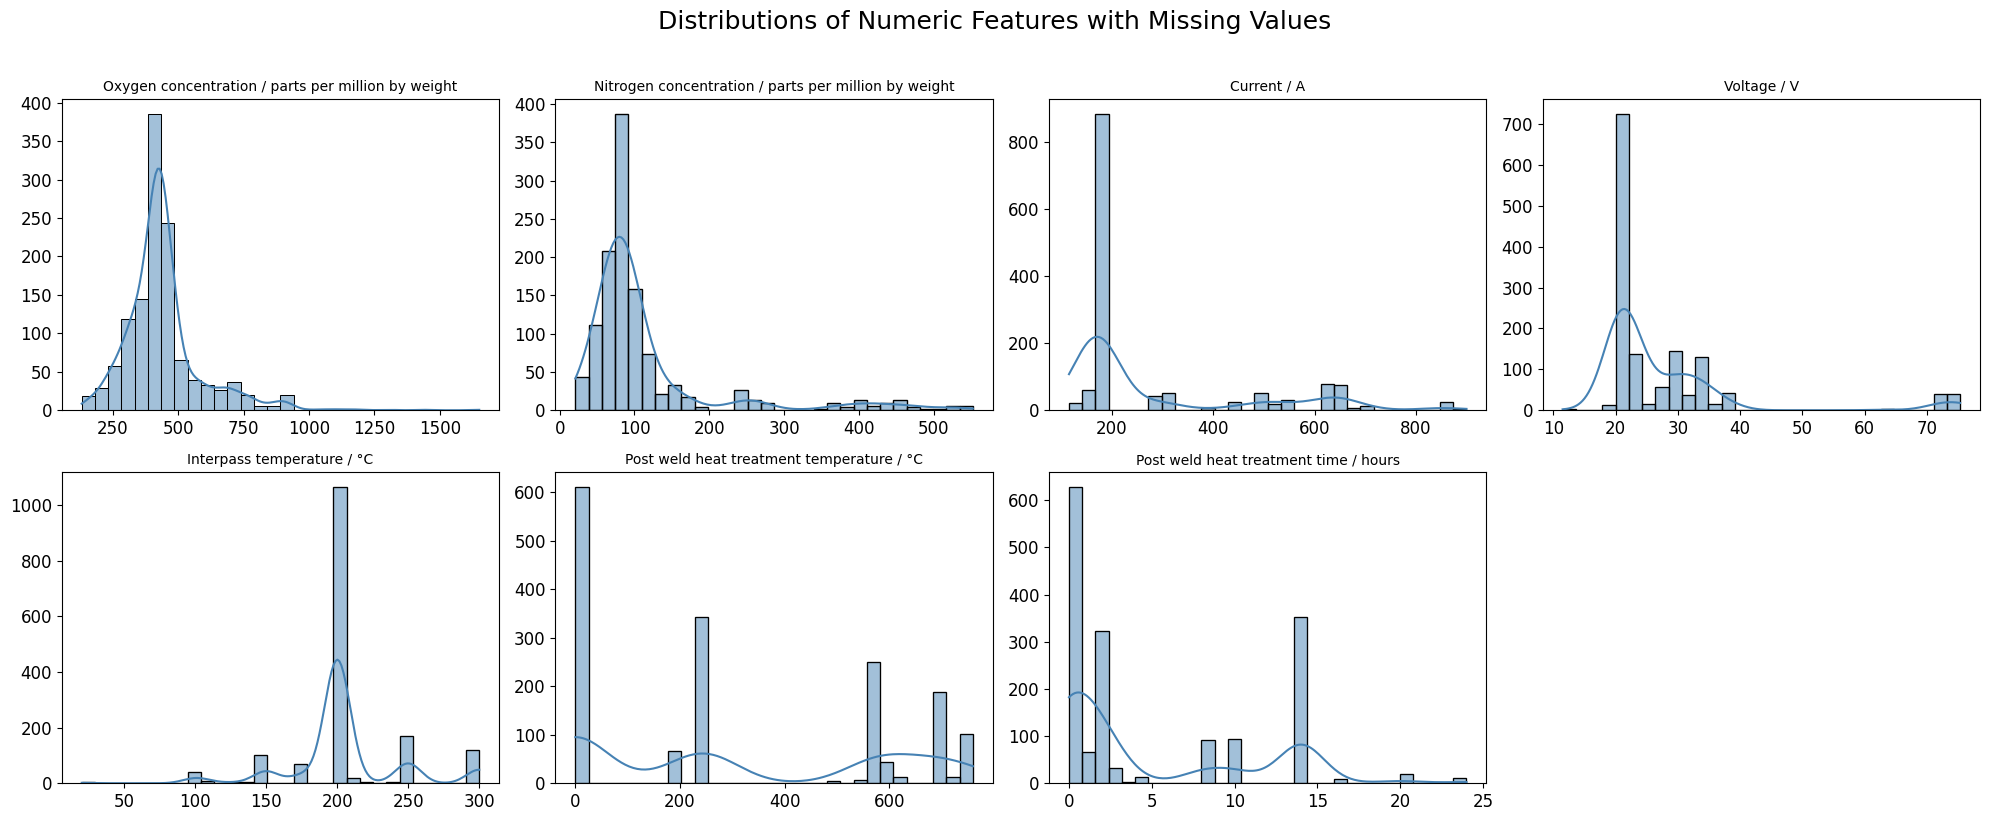

In [170]:
# Identify columns with missing values
missing_cols = X.columns[X.isnull().any()]

print(f"{len(missing_cols)} columns have missing values.")

# Set up grid layout
n_cols = 4
n_rows = int(np.ceil(len(missing_cols) / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))
plt.suptitle("Distributions of Numeric Features with Missing Values", fontsize=18, y=1.02)

for i, col in enumerate(missing_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(X[col], bins=30, kde=True, color='steelblue')
    plt.title(col, fontsize=10)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()

plt.show()


In [171]:
# Identify columns with missing values
missing_cols = X.columns[X.isnull().any()]

# Initialize a dictionary for strategies
imputation_strategies = {}

# Decide strategy based on skewness and number of unique values
for col in missing_cols:
    unique_vals = X[col].nunique(dropna=True)
    
    # Treat as "categorical-like" if few unique numeric values (e.g., <= 10)
    if unique_vals <= 20:
        imputation_strategies[col] = 'most_frequent'
        continue

    skew = X[col].skew()
    if abs(skew) < 0.5:
        imputation_strategies[col] = 'mean'
    else:
        imputation_strategies[col] = 'median'

# Show summary
print("Imputation strategy per column:")
for col, strategy in imputation_strategies.items():
    print(f"  {col:40s} → {strategy}")

Imputation strategy per column:
  Oxygen concentration / parts per million by weight → median
  Nitrogen concentration / parts per million by weight → median
  Current / A                              → median
  Voltage / V                              → median
  Interpass temperature / °C               → most_frequent
  Post weld heat treatment temperature / °C → most_frequent
  Post weld heat treatment time / hours    → median


In [172]:

from sklearn.impute import SimpleImputer
# ---- Apply imputations column-wise ---- #
imputed_X = X.copy()

for col, strategy in imputation_strategies.items():
    imputer = SimpleImputer(strategy=strategy)
    imputed_X[[col]] = imputer.fit_transform(X[[col]])

# Check results
print("\n==> Imputation complete!")
print(f"Remaining missing values: {imputed_X.isnull().sum().sum()}")



==> Imputation complete!
Remaining missing values: 0


In [173]:
#imputed_X.info()

In [174]:
X = imputed_X

### correlation heatmap

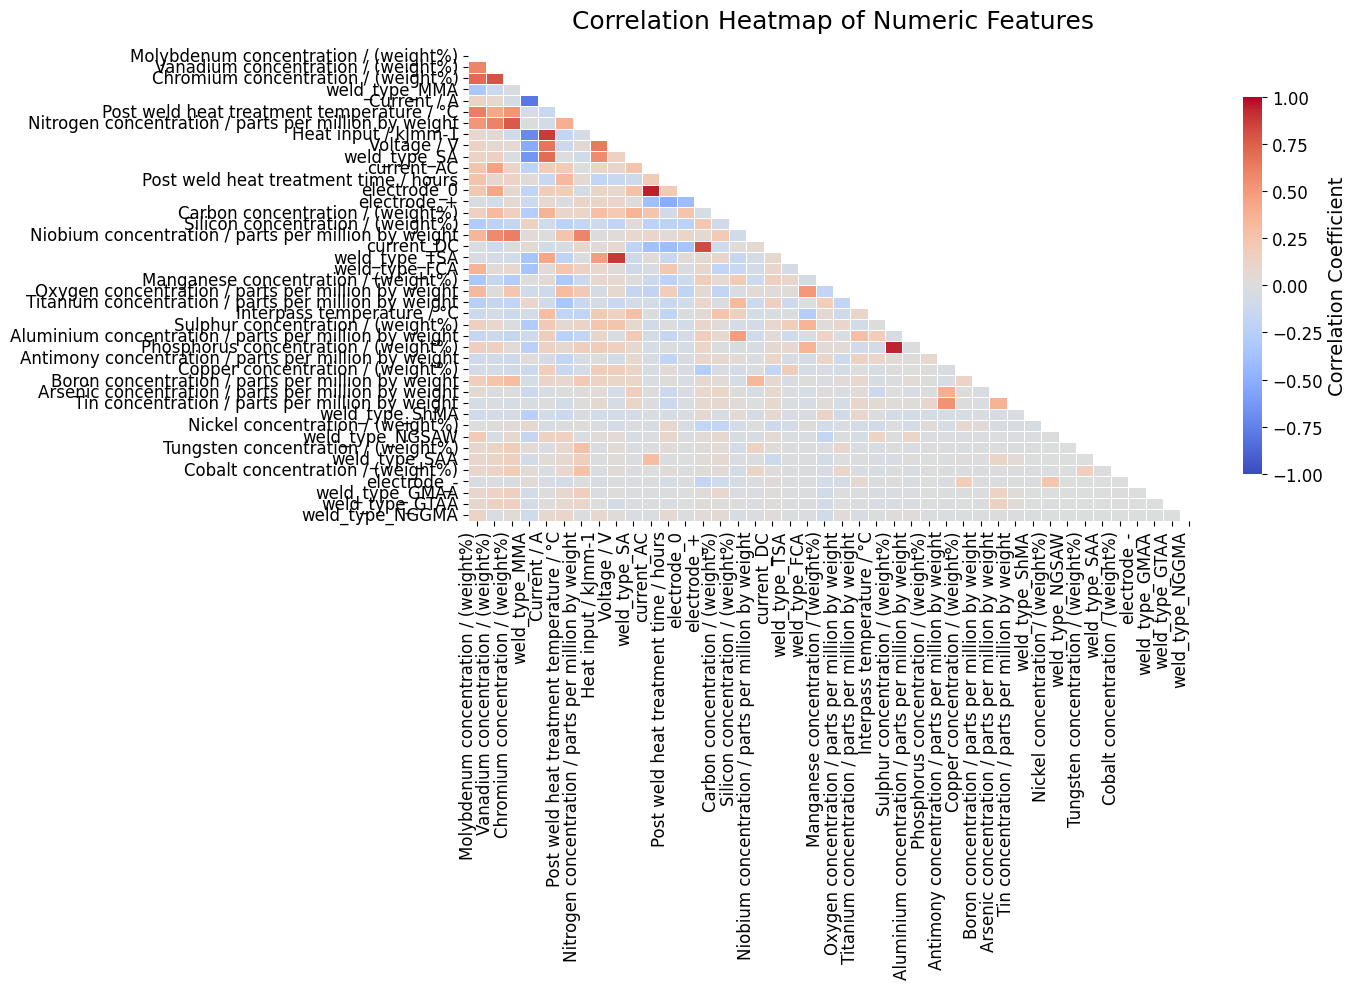

In [175]:
# Compute correlation matrix (Pearson by default)
corr_matrix = X.corr(method='pearson')

# Sort features by overall correlation strength (optional but helpful)
corr_order = corr_matrix.abs().mean().sort_values(ascending=False).index
corr_matrix = corr_matrix.loc[corr_order, corr_order]

# Mask the upper triangle (since correlation is symmetric)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    annot=False,             # show numeric values
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'}
)

# Titles and styling
plt.title("Correlation Heatmap of Numeric Features", fontsize=18, pad=16)
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [176]:
high_corr_pairs = (
    corr_matrix.abs()
    .unstack()
    .sort_values(ascending=False)
    .drop_duplicates()
)
high_corr_pairs[high_corr_pairs > 0.7]


Molybdenum concentration / (weight%)                  Molybdenum concentration / (weight%)    1.000000
electrode_0                                           current_AC                              0.950010
Sulphur concentration / (weight%)                     Phosphorus concentration / (weight%)    0.941055
Voltage / V                                           weld_type_TSA                           0.884057
Current / A                                           Heat input / kJmm-1                     0.877200
electrode_+                                           current_DC                              0.831369
Chromium concentration / (weight%)                    Vanadium concentration / (weight%)      0.799663
weld_type_MMA                                         Current / A                             0.796863
Nitrogen concentration / parts per million by weight  Chromium concentration / (weight%)      0.770989
Chromium concentration / (weight%)                    Molybdenum concentr

🔎 Top correlated feature pairs:

                           Feature 1                                            Feature 2  Correlation
                          current_AC                                          electrode_0     0.950010
   Sulphur concentration / (weight%)                 Phosphorus concentration / (weight%)     0.941055
                         Voltage / V                                        weld_type_TSA     0.884057
                         Current / A                                  Heat input / kJmm-1     0.877200
                         electrode_+                                           current_DC     0.831369
  Vanadium concentration / (weight%)                   Chromium concentration / (weight%)     0.799663
                       weld_type_MMA                                          Current / A     0.796863
  Chromium concentration / (weight%) Nitrogen concentration / parts per million by weight     0.770989
Molybdenum concentration / (weight%)    

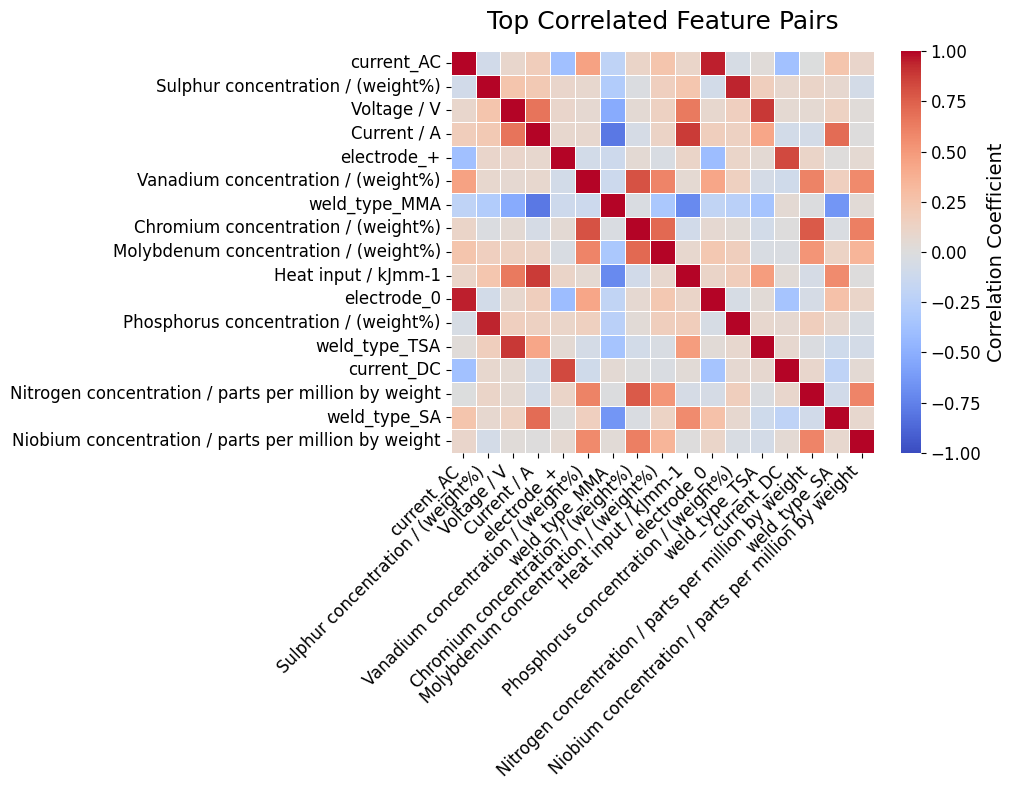

In [177]:
# Melt the corr matrix to long form for easy filtering
corr_pairs = (
    corr_matrix.abs()
    .unstack()
    .reset_index()
    .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'})
)

# Remove self-correlations and duplicate pairs
corr_pairs = corr_pairs[corr_pairs['Feature 1'] != corr_pairs['Feature 2']]
corr_pairs = corr_pairs.drop_duplicates(subset=['Correlation'])

# Sort by strongest correlations
top_corr = corr_pairs.sort_values(by='Correlation', ascending=False).head(15)

# Print top correlations
print("🔎 Top correlated feature pairs:\n")
print(top_corr.to_string(index=False))

# Focus heatmap on the unique features involved in the top correlations
top_features = pd.unique(top_corr[['Feature 1', 'Feature 2']].values.ravel('K'))
focused_corr = corr_matrix.loc[top_features, top_features]

# Plot focused annotated heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    focused_corr,
    cmap='coolwarm',
    center=0,
    vmin=-1, vmax=1,
    annot=False,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)

plt.title("Top Correlated Feature Pairs", fontsize=18, pad=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


| Pair                                           | Correlation | Recommended removal                                 | Rationale                                                                                                                               |
| ---------------------------------------------- | ----------- | --------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **current_AC ↔ electrode_0**                   | 0.95        | **Remove `electrode_0`**                            | Current is a direct process parameter; electrode type may encode it indirectly.                                                         |
| **Sulphur (%) ↔ Phosphorus (%)**               | 0.94        | **Keep only one (e.g., `Sulphur`)**                 | Both are residual elements with similar metallurgical effects (impurities).                                                             |
| **Voltage (V) ↔ weld_type_TSA**                | 0.88        | **Remove `weld_type_TSA`**                          | `Voltage` is a numeric process measure; weld type likely categorical encoding.                                                          |
| **Current (A) ↔ Heat input (kJ/mm)**           | 0.88        | **Remove `Heat input`** (or compute it later)       | `Heat input` is derived from current, voltage, and travel speed — redundant.                                                            |
| **current_DC ↔ electrode_+**                   | 0.83        | **Remove `electrode_+`**                            | Same logic as AC/electrode_0, electrode likely encodes current polarity.                                                               |
| **Chromium (%) ↔ Vanadium (%)**                | 0.80        | Keep both (conditionally)                           | Both are alloying elements; correlation may arise from steel composition grouping. Retain both unless regularization or VIF flags them. |
| **Current (A) ↔ weld_type_MMA**                | 0.80        | **Remove `weld_type_MMA`**                          | Same as TSA — categorical encoding correlating with current.                                                                            |
| **Chromium (%) ↔ Nitrogen (ppm)**              | 0.77        | Keep both                                           | Not directly redundant, chemical composition correlation is natural.                                                                   |
| **Chromium (%) ↔ Molybdenum (%)**              | 0.72        | Keep both                                           | Common alloying synergy; not redundant.                                                                                                 |
| **Heat input ↔ weld_type_MMA**                 | 0.71        | `weld_type_MMA` again likely redundant              | Derived correlation from process parameters.                                                                                            |
| **Current (A) ↔ weld_type_SA**                 | 0.70        | Possibly remove `weld_type_SA`                      | Same reasoning.                                                                                                                         |
| **Current (A) ↔ Voltage (V)**                  | 0.67        | Keep both                                           | Physical relation, but both essential to characterize welding parameters.                                                               |
| **Voltage (V) ↔ Heat input (kJ/mm)**           | 0.65        | Remove `Heat input`                                 | Again, derivative quantity.                                                                                                             |


In [178]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Compute VIF for numeric columns
vif_data = pd.DataFrame()
vif_data["feature"] = X.select_dtypes(include=[np.number]).columns
vif_data["VIF"] = [variance_inflation_factor(X.select_dtypes(include=[np.number]).values, i)
                   for i in range(len(vif_data["feature"]))]

print(vif_data.sort_values(by="VIF", ascending=False).head(15))


c:\Users\Ouissal\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                 feature        VIF
41                           electrode_0        inf
37                            current_AC        inf
34                         weld_type_SAA        inf
30                         weld_type_MMA  89.499266
33                          weld_type_SA  34.931221
36                         weld_type_TSA  22.117823
21                           Current / A  17.841392
22                           Voltage / V  14.514949
4   Phosphorus concentration / (weight%)  13.103994
3      Sulphur concentration / (weight%)  13.077930
27                         weld_type_FCA  11.677759
6     Chromium concentration / (weight%)  10.889693
39                           electrode_+   9.130566
38                            current_DC   7.017773
8     Vanadium concentration / (weight%)   6.825603


| Feature            | VIF  | Recommendation      | Reason                                                                                                                                  |
| ------------------ | ---- | ------------------- | --------------------------------------------------------------------------------------------------------------------------------------- |
| **electrode_0**    | ∞    | Remove            | Perfectly collinear with `current_AC` (probably encoding the same condition).                                                           |
| **current_AC**     | ∞    | Remove            | Remove one of the two (`electrode_0` *or* `current_AC`), not both — prefer to **keep `current_AC`** since it’s numeric and more direct. |
| **weld_type_SAA**  | ∞    | Remove            | Perfectly correlated with another weld-type indicator (likely one-hot dummy variable issue).                                            |
| **weld_type_MMA**  | 89.5 | Remove            | Very high VIF — correlated with current, voltage, and other weld-type columns.                                                          |
| **weld_type_SA**   | 34.9 | Remove            | Strong collinearity with other weld types and current.                                                                                  |
| **weld_type_TSA**  | 22.1 | Remove            | Same — part of one-hot encoded set.                                                                                                     |
| **Current / A**    | 17.8 | Consider keeping | Important process variable, but correlated with voltage and heat input. Drop if `current_AC` already captures it.                       |
| **Voltage / V**    | 14.5 | Keep             | Essential independent process parameter — unless derived duplicates exist.                                                              |
| **Phosphorus (%)** | 13.1 | Remove           | Highly correlated with Sulphur — keep only one.                                                                                         |
| **Sulphur (%)**    | 13.1 | Keep              | Represents impurity content — keep one.                                                                                                 |
| **weld_type_FCA**  | 11.7 | Remove            | Another weld-type indicator; one-hot redundancy.                                                                                        |
| **Chromium (%)**   | 10.9 | Keep             | Important alloying element; moderate multicollinearity, but meaningful.                                                                 |
| **electrode_+**    | 9.1  | Remove            | Redundant with `current_DC`.                                                                                                            |
| **current_DC**     | 7.0  | Keep             | Represents another welding current mode; not problematic alone.                                                                         |
| **Vanadium (%)**   | 6.8  | Keep              | Reasonable; mild correlation but useful metallurgical input.                                                                            |


In [179]:
to_remove = [
    # One-hot redundant categorical encodings
    'weld_type_SAA',
    'weld_type_MMA',
    'weld_type_SA',
    'weld_type_TSA',
    'weld_type_FCA',
    
    # Perfect or near-perfect correlations
    'electrode_0',
    'electrode_+',
    'Heat input / kJmm-1',
    
    # Redundant chemistry
    'Phosphorus concentration / (weight%)'
]


In [180]:
X_reduced = X.drop(columns=to_remove, errors='ignore')

In [181]:
#X_reduced.info()

In [182]:
X = X_reduced

In [183]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X.select_dtypes(include=[np.number]).columns
vif_data["VIF"] = [variance_inflation_factor(X.select_dtypes(include=[np.number]).values, i)
                   for i in range(len(vif_data["feature"]))]

print(vif_data.sort_values(by="VIF", ascending=False))

                                              feature        VIF
22                         Interpass temperature / °C  28.395668
11  Oxygen concentration / parts per million by we...  16.075132
0                    Carbon concentration / (weight%)  15.894528
21                                        Voltage / V  14.371719
1                   Silicon concentration / (weight%)  13.931877
2                 Manganese concentration / (weight%)  13.705921
5                  Chromium concentration / (weight%)  11.277019
31                                         current_DC   9.434441
20                                        Current / A   8.838899
13  Nitrogen concentration / parts per million by ...   8.524326
7                  Vanadium concentration / (weight%)   7.154619
23          Post weld heat treatment temperature / °C   4.815959
6                Molybdenum concentration / (weight%)   4.748617
24              Post weld heat treatment time / hours   2.461276
3                   Sulph

| Feature                         | VIF      | Likely reason                                                                                                               | Recommendation                                                                                    |
| ------------------------------- | -------- | --------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| **Interpass temperature / °C**  | **28.4** | Probably correlated with **Voltage**, **Current**, or **Post-weld heat treatment temperature** — all reflect thermal input. | *Remove* (keep process parameters like `Current / A`, `Voltage / V` instead).                   |
| **Oxygen concentration (ppm)**  | **16.1** | Often correlated with **Carbon, Manganese, or Silicon** — these tend to rise/fall together with oxidation level.            | *Consider removing or standardizing* — not essential if you already have alloying data.        |
| **Carbon concentration (%)**    | **15.9** | Highly correlated with **Manganese**, **Silicon**, and sometimes **Chromium** (steel chemistry cluster).                    | *Keep one representative* (usually Carbon).                                                    |
| **Voltage / V**                 | **14.4** | Correlates with **Current / A** and **Interpass temperature** — both reflect heat input.                                    | *Keep* if you dropped `Heat input`, but if `Current` already included, you can drop `Voltage`. |
| **Silicon concentration (%)**   | **13.9** | Correlated with **Manganese** and **Carbon** — chemical group effect.                                                       | *Remove*, since it’s redundant with Carbon or Manganese.                                        |
| **Manganese concentration (%)** | **13.7** | Similar story — correlated with other major alloying elements.                                                              | *Keep* either Manganese or Carbon, not both.                                                   |
| **Chromium concentration (%)**  | **11.3** | Correlated with other alloying elements (Mo, V, Nb).                                                                        | *Keep* — major mechanical influencer.                                                           |
| **current_DC**                  | **9.4**  | Mild correlation with current/voltage but within tolerance.                                                                 | *Keep*.                                                                                         |
| **Current / A**                 | **8.8**  | Slightly high but acceptable.                                                                                               | *Keep*.                                                                                         |


In [184]:
to_remove_more = [
    'Interpass temperature / °C',                 # Highly correlated with voltage/current
    'Silicon concentration / (weight%)',          # Redundant alloying element
    'Manganese concentration / (weight%)',        # Strongly correlated with C and Si — pick one
    'Oxygen concentration / parts per million by weight',  # Linked to chemistry cluster
    # Optional tradeoff: drop either Voltage or Current, but not both
    'Voltage / V'
]


In [185]:
X_reduced = X.drop(columns=to_remove_more, errors='ignore')

from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_reduced.select_dtypes(include=[np.number]).columns
vif_data["VIF"] = [variance_inflation_factor(X_reduced.select_dtypes(include=[np.number]).values, i)
                   for i in range(len(vif_data["feature"]))]

vif_data.sort_values(by="VIF", ascending=False)


,feature,VIF
0,Carbon concentration / (weight%),10.499178
3,Chromium concentration / (weight%),10.261048
10,Nitrogen concentration / parts per million by ...,7.935549
5,Vanadium concentration / (weight%),6.408924
26,current_DC,6.353053
17,Current / A,5.233597
18,Post weld heat treatment temperature / °C,4.413838
4,Molybdenum concentration / (weight%),4.378804
13,Niobium concentration / parts per million by w...,2.359527
1,Sulphur concentration / (weight%),2.357106


----------------> All good now :)))

### Self-training

Self-Training consists on a base classifier that iteratively generates new labeled samples from the unlabeled ones to increase the training data and feed it again to classifier for re-training.

In [186]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier

In [187]:
y = weld_df[target_cols]


In [188]:
print(X.shape)
print(y.shape)

(1652, 33)
(1652, 8)


In [189]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1652 entries, 161 to 1061
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Yield strength / MPa             780 non-null    float64
 1   Ultimate tensile strength / MPa  738 non-null    float64
 2   Elongation / %                   700 non-null    float64
 3   Reduction of Area / %            705 non-null    float64
 4   Charpy temperature / °C          879 non-null    float64
 5   Charpy impact toughness / J      879 non-null    float64
 6   Hardness / kgmm-2                80 non-null     float64
 7   50 % FATT                        31 non-null     float64
dtypes: float64(8)
memory usage: 116.2 KB


In [190]:
quality_features = [
    'Yield strength / MPa',
    'Ultimate tensile strength / MPa',
    'Elongation / %',
    'Reduction of Area / %',
    'Charpy temperature / °C',
    'Charpy impact toughness / J'
]
# we exclude Hardness / kgmm-2 and 50 % FATT because they are too sparse

In [191]:
y = y[quality_features]

In [192]:
# Identify rows with complete target data
mask = y[quality_features].notna().all(axis=1)
mask

161     False
1089     True
1506    False
559     False
804     False
        ...  
715     False
905      True
1096     True
235     False
1061    False
Length: 1652, dtype: bool

In [193]:
X = X.loc[mask].reset_index(drop=True)
y_clean = y.loc[mask].reset_index(drop=True)

print(f" Remaining samples after dropping missing targets: {len(X)}")


 Remaining samples after dropping missing targets: 134


In [194]:
X, y_clean

(     Carbon concentration / (weight%)  Silicon concentration / (weight%)  \
 0                               0.047                               0.31   
 1                               0.046                               0.31   
 2                               0.075                               0.33   
 3                               0.075                               0.32   
 4                               0.037                               0.30   
 ..                                ...                                ...   
 129                             0.094                               0.16   
 130                             0.073                               0.34   
 131                             0.077                               0.29   
 132                             0.080                               0.67   
 133                             0.042                               0.25   
 
      Manganese concentration / (weight%)  Sulphur concentration / (weight

In [195]:
y = y_clean.copy()

In [196]:
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y[quality_features])

# Average normalized values → overall weld quality index
y['weld_quality_score'] = y_scaled.mean(axis=1)

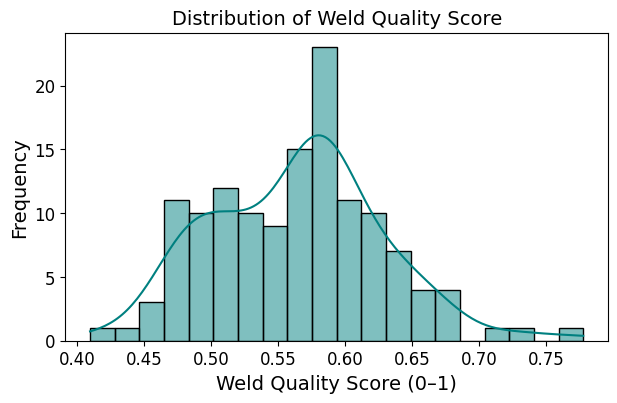

In [197]:
# Visualize distribution
plt.figure(figsize=(7,4))
sns.histplot(y['weld_quality_score'], bins=20, kde=True, color='teal')
plt.title("Distribution of Weld Quality Score", fontsize=14)
plt.xlabel("Weld Quality Score (0–1)")
plt.ylabel("Frequency")
plt.show()

In [198]:
y['weld_quality_class'] = pd.qcut(
    y['weld_quality_score'],
    q=3, 
    labels=['Low', 'Medium', 'High']
)

In [199]:
print(y['weld_quality_class'].value_counts())

weld_quality_class
Low       45
High      45
Medium    44
Name: count, dtype: int64


In [200]:
# Convert target to categorical codes for sklearn
y_encoded = y['weld_quality_class'].astype('category').cat.codes

# Split into labeled/unlabeled sets
X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(
    X, y_encoded, 
    test_size=0.7, stratify=y_encoded, random_state=42
)

In [201]:
X_labeled

,Carbon concentration / (weight%),Silicon concentration / (weight%),Manganese concentration / (weight%),Sulphur concentration / (weight%),Nickel concentration / (weight%),Chromium concentration / (weight%),Molybdenum concentration / (weight%),Vanadium concentration / (weight%),Copper concentration / (weight%),Cobalt concentration / (weight%),...,Post weld heat treatment temperature / °C,Post weld heat treatment time / hours,weld_type_GMAA,weld_type_GTAA,weld_type_NGGMA,weld_type_NGSAW,weld_type_ShMA,current_AC,current_DC,electrode_-
68,0.052,0.33,1.81,0.007,0.00,1.100,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
72,0.037,0.30,0.65,0.008,0.00,0.000,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
42,0.076,0.33,1.04,0.007,0.00,0.000,0.00,0.0610,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
47,0.080,0.62,1.85,0.013,0.45,0.050,0.01,0.0100,0.81,0.0,...,0.0,0.0,0,0,0,0,0,0,1,0
25,0.041,0.31,0.98,0.008,3.46,0.000,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
44,0.040,0.33,0.60,0.006,0.00,0.510,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
79,0.080,0.68,1.94,0.013,1.54,0.050,0.01,0.0100,0.85,0.0,...,0.0,0.0,0,0,0,0,0,0,1,0
8,0.044,0.35,1.43,0.007,0.00,0.000,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
90,0.053,0.35,1.83,0.007,1.06,0.000,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0
69,0.045,0.33,1.85,0.007,0.00,0.000,0.00,0.0000,0.00,0.0,...,580.0,2.0,0,0,0,0,0,0,1,0


In [204]:
# Simulate unlabeled samples by masking their labels
y_unlabeled[:] = -1   # SelfTrainingClassifier uses -1 for unlabeled
y_combined = np.concatenate([y_labeled, y_unlabeled])
X_combined = pd.concat([X_labeled, X_unlabeled])

#### SVM

In [207]:
from sklearn.model_selection import StratifiedKFold
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.svm import SVC

n_splits = 5
base_classifier = SVC(probability=True, gamma=0.001, random_state=42)
self_training_model = SelfTrainingClassifier(base_classifier, threshold=0.7)

skfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

In [208]:
from sklearn.metrics import accuracy_score, roc_auc_score

# Perform stratified K-Fold self-training
for fold, (train_index, test_index) in enumerate(skfolds.split(X, y_encoded)):
    print(f"\n🔹 Fold {fold+1}/{n_splits}")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Simulate semi-supervised setting (unlabeled data = -1)
    rng = np.random.RandomState(42 + fold)
    unlabeled_mask = rng.rand(len(y_train)) < 0.6  # 60% unlabeled
    y_train_semi = y_train.copy()
    y_train_semi[unlabeled_mask] = -1

    # Train self-training model
    self_training_model.fit(X_train, y_train_semi)

    # Predict
    y_pred = self_training_model.predict(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    # roc_auc for multi-class handled via 'ovo' (one-vs-one)
    auc = roc_auc_score(y_test, self_training_model.predict_proba(X_test), multi_class='ovo')

    scores_accuracy[fold] = acc
    scores_auc[fold] = auc

    print(f"Fold {fold+1} → Accuracy: {acc:.3f} | AUC: {auc:.3f}")



🔹 Fold 1/5
Fold 1 → Accuracy: 0.481 | AUC: 0.488

🔹 Fold 2/5
Fold 2 → Accuracy: 0.519 | AUC: 0.794

🔹 Fold 3/5
Fold 3 → Accuracy: 0.481 | AUC: 0.586

🔹 Fold 4/5
Fold 4 → Accuracy: 0.259 | AUC: 0.636

🔹 Fold 5/5
Fold 5 → Accuracy: 0.615 | AUC: 0.652


In [209]:
# Aggregate results
print("\n✅ Cross-validation results:")
print(f"Mean Accuracy: {scores_accuracy.mean():.3f} ± {scores_accuracy.std():.3f}")
print(f"Mean AUC: {scores_auc.mean():.3f} ± {scores_auc.std():.3f}")


✅ Cross-validation results:
Mean Accuracy: 0.471 ± 0.117
Mean AUC: 0.631 ± 0.100


#### Random Forest

In [210]:
base_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

self_training_model = SelfTrainingClassifier(
    base_rf,
    threshold=0.8,  # only add very confident pseudo-labels
    verbose=True
)

# Cross validation setup
n_splits = 5
skfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

# Train + evaluate across folds
for fold, (train_index, test_index) in enumerate(skfolds.split(X, y_encoded)):
    print(f"\n🔹 Fold {fold+1}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Simulate unlabeled data (semi-supervised)
    rng = np.random.RandomState(42 + fold)
    unlabeled_mask = rng.rand(len(y_train)) < 0.5  # 50% unlabeled
    y_train_semi = y_train.copy()
    y_train_semi[unlabeled_mask] = -1

    # Fit the semi-supervised Random Forest
    self_training_model.fit(X_train, y_train_semi)

    # Predict on test set
    y_pred = self_training_model.predict(X_test)
    y_proba = self_training_model.predict_proba(X_test)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class='ovo')

    scores_accuracy[fold] = acc
    scores_auc[fold] = auc

    print(f"✅ Fold {fold+1} → Accuracy: {acc:.3f} | AUC: {auc:.3f}")

# Aggregate results

print("\n📈 Cross-validation results:")
print(f"Mean Accuracy: {scores_accuracy.mean():.3f} ± {scores_accuracy.std():.3f}")
print(f"Mean AUC: {scores_auc.mean():.3f} ± {scores_auc.std():.3f}")


🔹 Fold 1/5
End of iteration 1, added 14 new labels.
✅ Fold 1 → Accuracy: 0.519 | AUC: 0.728

🔹 Fold 2/5
End of iteration 1, added 9 new labels.
End of iteration 2, added 2 new labels.
End of iteration 3, added 2 new labels.
✅ Fold 2 → Accuracy: 0.704 | AUC: 0.912

🔹 Fold 3/5
End of iteration 1, added 16 new labels.
End of iteration 2, added 2 new labels.
✅ Fold 3 → Accuracy: 0.556 | AUC: 0.797

🔹 Fold 4/5
End of iteration 1, added 3 new labels.
End of iteration 2, added 4 new labels.
End of iteration 3, added 1 new labels.
End of iteration 4, added 1 new labels.
End of iteration 5, added 1 new labels.
✅ Fold 4 → Accuracy: 0.704 | AUC: 0.885

🔹 Fold 5/5
End of iteration 1, added 13 new labels.
End of iteration 2, added 5 new labels.
✅ Fold 5 → Accuracy: 0.731 | AUC: 0.879

📈 Cross-validation results:
Mean Accuracy: 0.642 ± 0.087
Mean AUC: 0.840 ± 0.068


### Label Spreading

In [212]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.semi_supervised import LabelSpreading

In [215]:
#  SEMI-SUPERVISED WELD QUALITY CLASSIFICATION Using Label Spreading

# Define Label Spreading model
label_spread = LabelSpreading(
    kernel='knn',       # or 'knn'
    gamma=0.25,         # controls influence of nearby samples
    max_iter=50
)

# K-Fold setup

n_splits = 5
skfolds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores_accuracy = np.empty(n_splits)
scores_auc = np.empty(n_splits)

#  Perform stratified K-Fold semi-supervised evaluation
for fold, (train_index, test_index) in enumerate(skfolds.split(X, y_encoded)):
    print(f"\n🔹 Fold {fold + 1}/{n_splits}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    # Simulate partially labeled data (e.g., 60% unlabeled)
    rng = np.random.RandomState(42 + fold)
    unlabeled_mask = rng.rand(len(y_train)) < 0.6
    y_train_semi = y_train.copy()
    y_train_semi[unlabeled_mask] = -1  # -1 indicates unlabeled in sklearn

    # Fit Label Spreading
    label_spread.fit(X_train, y_train_semi)

    # Predict on test data
    y_pred = label_spread.predict(X_test)
    y_proba = label_spread.predict_proba(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba, multi_class="ovo")

    scores_accuracy[fold] = acc
    scores_auc[fold] = auc

    print(f"✅ Fold {fold+1}: Accuracy = {acc:.3f} | AUC = {auc:.3f}")

# Report average results
print("\n📈 Cross-validation results:")
print(f"Mean Accuracy: {scores_accuracy.mean():.3f} ± {scores_accuracy.std():.3f}")
print(f"Mean AUC: {scores_auc.mean():.3f} ± {scores_auc.std():.3f}")



🔹 Fold 1/5
✅ Fold 1: Accuracy = 0.444 | AUC = 0.757

🔹 Fold 2/5
✅ Fold 2: Accuracy = 0.815 | AUC = 0.887

🔹 Fold 3/5
✅ Fold 3: Accuracy = 0.519 | AUC = 0.729

🔹 Fold 4/5
✅ Fold 4: Accuracy = 0.519 | AUC = 0.631

🔹 Fold 5/5
✅ Fold 5: Accuracy = 0.615 | AUC = 0.830

📈 Cross-validation results:
Mean Accuracy: 0.582 ± 0.128
Mean AUC: 0.767 ± 0.088


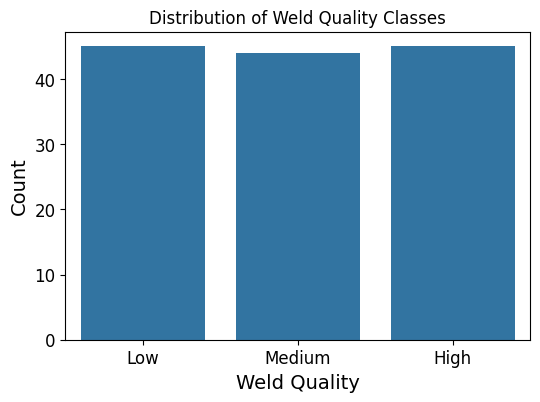

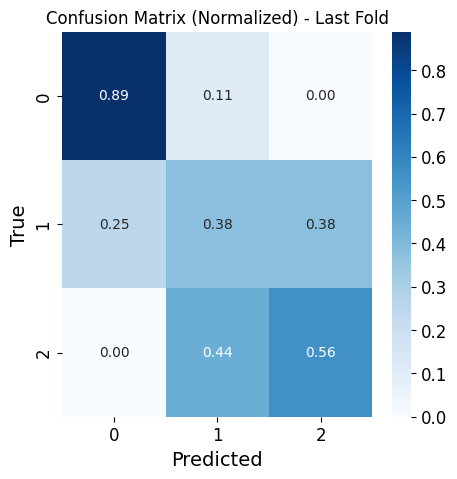

In [217]:

# Optional: visualize class distributions

plt.figure(figsize=(6,4))
sns.countplot(x=y["weld_quality_class"])
plt.title("Distribution of Weld Quality Classes")
plt.xlabel("Weld Quality")
plt.ylabel("Count")
plt.show()

# visualize one fold’s predictions
plt.figure(figsize=(5,5))
sns.heatmap(
    pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], normalize='index'),
    annot=True, cmap='Blues', fmt=".2f"
)
plt.title("Confusion Matrix (Normalized) - Last Fold")
plt.show()